# Robot Calibration

## Nominal Robot
- A nominal robot model:
    - Represents what the robot manufacturer intended as a kinematic model
    - Is mathematically ideal

In [1]:
from pybotics.robot import Robot
from pybotics.predefined_models import ur10

nominal_robot = Robot.from_parameters(ur10())

In [2]:
import pandas as pd

def display_robot_kinematics(robot: Robot):
    df = pd.DataFrame(robot.kinematic_chain.matrix)
    df.columns = ["alpha", "a", "theta", "d"]
    display(df)

display_robot_kinematics(nominal_robot)

,alpha,a,theta,d
0,0.000000,0.0,0.000000,118.0
1,1.570796,0.0,3.141593,0.0
2,0.000000,612.7,0.000000,0.0
3,0.000000,571.6,0.000000,163.9
4,-1.570796,0.0,0.000000,115.7
5,1.570796,0.0,3.141593,92.2


## *Real* Robots
- *Real* robots do not conform perfectly to the nominal parameters
- Small errors in the robot model can generate large errors in Cartesian position
- Sources of errors include, but are not limited to:
    - Kinematic errors
        - Mechanical tolerances
        - Angle offsets
    - Non-kinematic errors
        - Joint stiffness
        - Gravity
        - Temperature
        - Friction

In [3]:
import numpy as np
from copy import deepcopy

real_robot = deepcopy(nominal_robot)

# let's pretend our real robot has small joint offsets
# in real life, this would be a joint mastering issue (level-1 calibration)
# https://en.wikipedia.org/wiki/Robot_calibration
for link in real_robot.kinematic_chain.links:
    link.theta += np.random.uniform(
        low=np.deg2rad(-0.1),
        high=np.deg2rad(0.1)
    )

display_robot_kinematics(real_robot)

,alpha,a,theta,d
0,0.000000,0.0,-0.001602,118.0
1,1.570796,0.0,3.140136,0.0
2,0.000000,612.7,0.000937,0.0
3,0.000000,571.6,0.001712,163.9
4,-1.570796,0.0,0.001548,115.7
5,1.570796,0.0,3.141530,92.2


## Get *Real* (aka Measured) Poses
- In real life, these poses would be measured using metrology equipment (e.g., laser tracker, CMM)

In [4]:
joints = []
positions = []
for i in range(1000):
    q = real_robot.random_joints()
    pose = real_robot.fk(q)
    
    joints.append(q)
    positions.append(pose[:-1,-1])

In [5]:
pd.DataFrame(joints).describe()

,0,1,2,3,4,5
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.024511,-0.090671,0.024519,0.013319,0.057824,0.002825
std,1.845469,1.810471,1.833426,1.839980,1.809561,1.826789
min,-3.120738,-3.136021,-3.140768,-3.138327,-3.133358,-3.141046
25%,-1.644452,-1.625226,-1.578201,-1.574109,-1.508009,-1.603747
50%,-0.075271,-0.169728,-0.115088,0.011472,0.119836,0.036910
75%,1.610011,1.517423,1.630127,1.642295,1.594479,1.579081
max,3.135209,3.136369,3.123256,3.137543,3.135128,3.138303


In [6]:
pd.DataFrame(positions, columns=['x','y','z']).describe()

,x,y,z
count,1000.000000,1000.000000,1000.000000
mean,-1.557721,16.865645,157.122190
std,431.902411,443.597388,593.908420
min,-1301.872708,-1305.844242,-1170.407200
25%,-239.188266,-222.494618,-263.998275
50%,-15.584041,15.233551,151.033202
75%,265.114264,274.892061,616.140406
max,1267.182128,1260.598491,1404.081554


## Split Calibration and Validation Measures
- A portion of the measured configurations and positions should be set aside for validation after calibration (i.e., optimization)
    - This is to prevent/check the optimized model for overfitting

In [7]:
from sklearn.model_selection import train_test_split
split = train_test_split(joints, positions, test_size=0.3)

train_joints = split[0]
test_joints = split[1]

train_positions = split[2]
test_positions = split[3]

## Get Nominal Position Errors
- These nominal model is our starting point for calibration
- The errors are in millimetres 

In [8]:
from pybotics.optimization import compute_absolute_errors

nominal_errors = compute_absolute_errors(
    qs=test_joints,
    positions=test_positions,
    robot=nominal_robot
)

display(pd.Series(nominal_errors).describe())

count    300.000000
mean       1.261451
std        0.511057
min        0.331676
25%        0.871703
50%        1.143849
75%        1.693312
max        2.428211
dtype: float64

## Calibration

In [9]:
from pybotics.optimization import OptimizationHandler

# init calibration handler
handler = OptimizationHandler(nominal_robot)

# set handler to solve for theta parameters
kc_mask_matrix = np.zeros_like(nominal_robot.kinematic_chain.matrix, dtype=bool)
kc_mask_matrix[:,2] = True
display(kc_mask_matrix)

handler.kinematic_chain_mask = kc_mask_matrix.ravel()

array([[False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False]])

In [10]:
from scipy.optimize import least_squares
from pybotics.optimization import optimize_accuracy

# run optimization
result = least_squares(
    fun=optimize_accuracy,
    x0=handler.generate_optimization_vector(),
    args=(handler, train_joints, train_positions),
    verbose=2
)  # type: scipy.optimize.OptimizeResult

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.5073e+02                                    4.68e+05    
       1              7         5.3649e+01      5.97e+02       4.34e-03       1.35e+05    
       2              9         2.1031e-01      5.34e+01       2.17e-03       3.23e+03    
       3             12         9.2586e-03      2.01e-01       2.71e-04       1.36e+03    
       4             15         2.1788e-04      9.04e-03       3.39e-05       2.15e+02    
       5             18         4.5223e-05      1.73e-04       4.24e-06       1.25e+02    
       6             20         1.2495e-06      4.40e-05       2.12e-06       3.44e+00    
       7             22         9.3713e-07      3.12e-07       1.06e-06       7.69e+00    
       8             24         4.6008e-07      4.77e-07       2.65e-07       7.89e+00    
       9             25         8.7686e-08      3.72e-07       2.65e-07       5.52e+00    

## Results
- A calibrated robot model is never perfect in real life
    - The goal is often to reduce the max error under a desired threshold

In [11]:
calibrated_robot = handler.robot
calibrated_errors = compute_absolute_errors(
    qs=test_joints,
    positions=test_positions,
    robot=calibrated_robot
)

display(pd.Series(calibrated_errors).describe())

count    300.000000
mean       0.000007
std        0.000003
min        0.000001
25%        0.000004
50%        0.000007
75%        0.000009
max        0.000012
dtype: float64

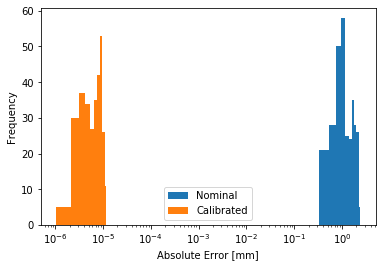

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.xscale("log")
plt.hist(nominal_errors, color="C0", label="Nominal")
plt.hist(calibrated_errors, color="C1", label="Calibrated")

plt.legend()
plt.xlabel("Absolute Error [mm]")
plt.ylabel("Frequency")